# Using Whisper API to transcribe text using your Device Microphone

[`Audio Whisper API`](https://platform.openai.com/docs/guides/speech-to-text) is capable of translating and transcribing - putting speech into written form. It is powered by OpenAI's [`large-v2 Whisper model`](https://github.com/openai/whisper). 

We will record audio from your device's microphone and transcribe the audio using OpenAI's Audio Whisper API. This functionality is similar to clicking on the microphone 🎙️ icon in ChatGPT. Note that speech-to-text is not supported in the [ChatGPT for Web](http://chatgpt.com).

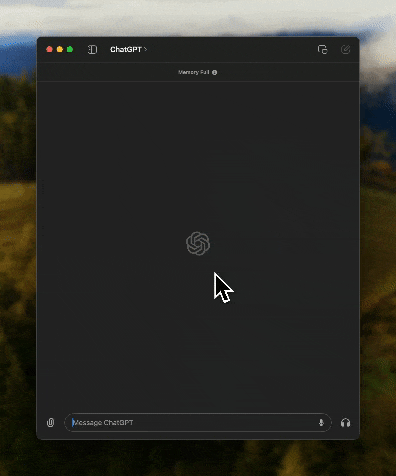

We'll be working with WAV files. Although larger than MP3, WAV files store audio in an uncompressed format, preserving audio quality. For transcription and translation purposes, high-quality audio can significantly improve accuracy.

We will go through three different code snippets making the main function:
1. **Recording** from your device microphone and storing it into a temporary file
2. **Transcribing or Translating** the audio to text using OpenAI's Whisper API
3. **Copying** the transcript to your clipboard for use (prompting, messaging, and etc.)

The entire code snippet will be available at [the end of this article](#main-code-snippet).

## Table of Contents

1. [Introduction](#using-audio-api-to-transcibe-text-from-your-device-microphone)
2. [Microphone Permissions](#microphone-permissions)
3. [Recording Audio](#recording-from-your-device-microphone)
4. [Transcribing Audio](#transcribing-your-recording)
5. [Copy and Paste Operations](#copying-to-clipboard)
6. [Main function and Demo](#main-code-snippet) 
7. [Troubleshooting](#troubleshooting)
8. [FAQ](#faq)
9. [Conclusion](#conclusion)





# Microphone Permissions

Before we start recording audio, ensure the necessary permissions to access the microphone.

### For Windows

1. Open Settings.
2. Go to Privacy > Microphone.
3. Ensure that "Microphone access for this device" is turned on.
4. Ensure that the app you're using (e.g., your Python IDE) is allowed to access the microphone.

### For MacOS

1. Open System Preferences.
2. Go to Security & Privacy > Privacy.
3. Select Microphone from the left-hand menu.
4. Ensure that the app you're using (e.g., your Python IDE) is checked.
___
# Setup
We need several libraries to record and process audio. 	
- pyaudio: To capture audio from the microphone.
- wave: To handle .wav files.
- tempfile: To create temporary files for storing recordings.
- simpleaudio: To play back audio (for debugging).

To install prerequisites, simply run the following code snippet.

In [4]:
# Prerequisites for the Python Modules
!brew install ffmpeg
!brew install portaudio

# Audio Processing
%pip install -q simpleaudio
%pip install -q pyaudio
%pip install -q wave

# Clipboard Management
%pip install -q pyperclip

# Speech Transcriber
%pip install -q openai
%pip install -q openai --upgrade # fix for  Cannot import name 'OpenAI' from 'openai'

# Securing API keys
%pip install -q python-dotenv

==> Downloading https://formulae.brew.sh/api/formula.jws.json
-#O#- #   #                                                                     
==> Downloading https://formulae.brew.sh/api/cask.jws.json
#=#=#                                                                           
To reinstall 7.0.2, run:
  brew reinstall ffmpeg
To reinstall 19.7.0, run:
  brew reinstall portaudio
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


___
# Recording Audio from your Device Microphone
We'll create a function that handles audio recording. This function will support both manual and timed recording:

1. **Set Up Temporary File.** We create a temporary file to store the recorded audio. This file will be deleted after use.

```python
temp_file = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
temp_file_name = temp_file.name
```

2. **Callback Function.** This function writes audio data to the temporary file while recording.
```python
def callback(data_input, frame_count, time_info, status):
    wav_file.writeframes(data_input)
    return None, pyaudio.paContinue
```

3. **Record Audio.** We set up the microphone to capture audio and save it to the temporary file.
- Open a `.wav` file for writing.
- Set the audio format: 1 channel, 16-bit samples, and 16000 Hz sample rate. 


- These values are standard for speech recognition tasks:
  - **1 channel (mono)**: Mono audio is sufficient for speech recognition and reduces the amount of data to process.
  - **16-bit samples**: Provides a good balance between audio quality and file size.
  - **16000 Hz sample rate**: Commonly used in speech recognition as it captures the necessary frequency range for human speech while keeping the file size manageable.


- Initialize PyAudio and start recording.

In [5]:
import pyaudio
import wave
import tempfile
import time


def record_audio(timed_recording=False, record_seconds=5):
    temp_file = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
    temp_file_name = temp_file.name

    def callback(data_input, frame_count, time_info, status):
        wav_file.writeframes(data_input)
        return None, pyaudio.paContinue

    with wave.open(temp_file_name, "wb") as wav_file:
        wav_file.setnchannels(1)  # Mono channel
        wav_file.setsampwidth(2)  # 16-bit samples
        wav_file.setframerate(16000)  # 16kHz sample rate

        audio = pyaudio.PyAudio()
        stream = audio.open(
            format=pyaudio.paInt16,
            channels=1,
            rate=16000,
            input=True,
            frames_per_buffer=1024,
            stream_callback=callback,
        )

        if timed_recording:
            print(f"Recording for {record_seconds} seconds...")
            time.sleep(record_seconds)
        else:
            input("Press Enter to stop recording...")

        stream.stop_stream()
        stream.close()
        audio.terminate()

    return temp_file_name

This function allows us to either record for a specific duration `(timed_recording=True)` or until the user presses Enter `(timed_recording=False)`.

___

# Transcribing or Translating Audio
Now, let's create a function to handle both transcription (for English) and translation (for non-English audio):

### 1. Import OpenAI Library 
We use the OpenAI library to access the Audio Whisper API. To use the OpenAI API, you need to set up your API key. You can obtain your API key from the [OpenAI website](https://platform.openai.com/account/api-keys). 

❗Important 
For security purposes, create a `.env` file in your project directory and store your OpenAI API key there. This way, you avoid hardcoding sensitive information directly in your code.

1. Create a `.env` file in the same directory as your notebook.
2. Add your OpenAI API key to the `.env` file in the following format:
    ```
    OPEN_AI_API_KEY=your_actual_api_key_here
    ```
3. Use the `dotenv` library to load the environment variables in your notebook.

Once you have your key, you can set it up in your code as follows:



In [6]:
from openai import OpenAI
from dotenv import load_dotenv
import os

# Load the OpenAI API key from the .env file
load_dotenv()
openai_api_key = os.getenv("OPEN_AI_API_KEY")

# Set up your OpenAI API client
client = OpenAI(api_key=openai_api_key)

### 2. Transcribe Audio
Open the recorded audio file and send it to the OpenAI Audio Whisper API for transcription. The API returns the text.

In [7]:
def process_audio(file_name, is_english=True, prompt=""):
    with open(file_name, "rb") as audio_file:
        if is_english:
            response = client.audio.transcriptions.create(
                model="whisper-1", file=audio_file, prompt=prompt
            )
        else:
            response = client.audio.translations.create(
                model="whisper-1", file=audio_file
            )

        return response.text.strip()

*Note:* You can use `prompt` to *guide* the transcription as you record. This is useful for various reasons, such as spelling correction, language specification, acronym recognition, filler word removal or inclusion, punctuation, and more.

View [Audio Whisper API's reference](https://platform.openai.com/docs/guides/speech-to-text/prompting) for more information. Alternatively, you can also look at prestontuggle's [AI Cookbook Recipe](https://cookbook.openai.com/examples/whisper_prompting_guide).

___
# Copying to Clipboard
###  1. Import pyperclip
This library helps copy text to the clipboard.

In [8]:
import pyperclip

### 2. Copy Transcription 
Copy the transcribed text to the clipboard and print a confirmation message.

In [9]:
def copy_to_clipboard(text):
    pyperclip.copy(text)
    print("Result copied to clipboard!")

### Main Code Snippet
Here’s the complete function that records audio, transcribes it, and copies the resulting text to the clipboard.

In [16]:
import simpleaudio as sa
import os


def transcribe_audio(
    debug: bool = False,
    prompt: str = "",
    timed_recording: bool = False,
    record_seconds: int = 5,
    is_english: bool = True,
) -> str:
    """
    Records audio from the microphone and transcribes or translates it using OpenAI's API.

    Args:
        debug (bool): If True, plays back the recorded audio for verification.
        prompt (str): A prompt to guide the transcription (only used for English).
        timed_recording (bool): If True, records for a set duration. If False, records until user input.
        record_seconds (int): The number of seconds to record if timed_recording is True.
        is_english (bool): If True, uses transcription. If False, uses translation to English.

    Returns:
        str: The transcription or translation of the recorded audio.
    """
    # Record audio
    temp_file_name = record_audio(timed_recording, record_seconds)

    # Debug playback
    if debug:
        print("Playing back recorded audio...")
        playback = sa.WaveObject.from_wave_file(temp_file_name)
        play_obj = playback.play()
        play_obj.wait_done()

    # Process audio (transcribe or translate)
    result = process_audio(temp_file_name, is_english, prompt)

    # Clean up temporary file
    os.remove(temp_file_name)

    # Copy result to clipboard
    copy_to_clipboard(result)

    return result

In [17]:
# Demo: Transcribe 5 seconds of spoken English with proper grammar and punctuation
result = transcribe_audio(
    debug=True,
    prompt="English spoken. Proper grammar and punctuation. Skip fillers.",
    timed_recording=True,
    record_seconds=5,
    is_english=True,
)
print("\nTranscription/Translation:", result)

Recording for 5 seconds...
Playing back recorded audio...
Result copied to clipboard!

Transcription/Translation: Hey, thanks for finishing this tutorial. I hope you found it helpful.


In [12]:
# Demo: Transcribe lengthy Filipino speech and translate into English with proper grammar and punctuation
result = transcribe_audio(
    debug=False,
    prompt="Filipino spoken. Proper grammar and punctuation. Skip fillers.",
    timed_recording=False,
    record_seconds=0,
    is_english=False,
)

print("\nTranscription/Translation:", result)

Result copied to clipboard!
Transcription/Translation: Hello, 1, 2, 3, 1, 2, 3.


# Troubleshooting

### Common Issues

1. **Microphone not working**:
   - Ensure that your microphone is properly connected and recognized by your device.
   - Check that the microphone is not muted and that the volume is turned up.
   - Verify that your application has permission to access the microphone (see [Microphone Permissions](#microphone-permissions)).

2. **Audio quality issues**:
   - Ensure you are in a quiet environment to reduce background noise.

3. **Transcription errors**:
   - Ensure that the audio file is clear and that the speaker’s voice is distinct.
   - For non-English audio, make sure `is_english` is set to False.
   - Try re-recording the audio if the transcription is not accurate.

4. **API key issues**:
- Double-check that your .env file is in the correct location and contains the correct API key
- Ensure that the python-dotenv library is installed and working correctly.

### Advanced Troubleshooting

1. **Debugging audio playback**:
   - Enable the `debug` parameter in the `transcribe_audio` function to listen to the recorded audio for quality verification.

2. **Handling large audio files**:
   - For longer recordings, consider splitting the audio into smaller chunks before transcription to improve accuracy and performance.

## Frequently Asked Questions (FAQ)
See Whisper Audio Whisper API's official FAQs [here](https://help.openai.com/en/articles/7031512-whisper-audio-api-faq).

**Q: How can I improve the transcription accuracy?**

- Ensure the recording environment is quiet and free from background noise.
- Speak clearly and at a moderate pace.
- Use a high-quality microphone if possible.
- For English transcription, use the `prompt` parameter to provide context or expected terminology.

**Q: Can I use this method to transcribe audio in other languages?**

- Yes, OpenAI’s Whisper model supports [multiple languages](https://platform.openai.com/docs/guides/speech-to-text/supported-languages%5C). Set `is_english=False` to use the translation feature, which will translate non-English audio to English text.

**Q: How do I choose between manual and timed recording?**

- Use `timed_recording=False` if you want to control the recording duration manually (press Enter to stop).
- Use `timed_recording=True` and set record_seconds to automatically stop recording after a specific duration.

## Conclusion

Congratulations! You have successfully learned how to create an audio transcription and translation tool using OpenAI's Whisper API. This tool can record audio from your device's microphone, process it (either transcribing English or translating other languages to English), and copy the result to your clipboard.

Feel free to explore further with the [API reference](https://platform.openai.com/docs/api-reference/audio) and modify the code to suit your needs.